In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input

In [4]:
df = pd.read_csv('data/diet_workout_dataset.csv')
df.head()

,HeartRate,BloodOxygenLevel,BodyTemperature,ExercisePaln,DietPlan
0,57,100,42,0,0
1,57,100,41,0,0
2,57,100,40,0,0
3,57,100,39,0,0
4,57,100,38,0,0


In [5]:
# process_data

'''
Process data which capable for feeding into ANN model
'''

def process_data(df):
    data = df.values
    X, Y = data[:, :3], data[:, 3:]

    scalar = StandardScaler()
    scalar.fit(X)

    X = scalar.transform(X)
    with open('weights/scalar - diet_workout_prediction.pkl', 'wb') as f:
        pickle.dump(scalar, f)

    return X, Y

In [6]:
X, Y = process_data(df)
X, Y = shuffle(X, Y)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

In [7]:
def MIMOModel(
              n_features=3, 
              n_outputs=4
              ):
    i = Input(shape=(n_features,))
    x = Dense(128, activation='relu')(i)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x) # to avoid overfitting

    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dropout(0.2)(x)

    o1 = Dense(n_outputs, activation='softmax', name='ExercisePaln')(x)
    o2 = Dense(n_outputs, activation='softmax', name='DietPlan')(x)

    model = Model(i, [o1, o2])
    return model

In [8]:
model = MIMOModel()
model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
            )

history = model.fit(
                    Xtrain, [Ytrain[:,0], Ytrain[:,1]],
                    validation_data=(Xtest, [Ytest[:,0], Ytest[:,1]]),
                    epochs=100,
                    batch_size=32
                    )

Epoch 1/100
65/65 [==============================] - 2s 8ms/step - loss: 2.6796 - ExercisePaln_loss: 1.2980 - DietPlan_loss: 1.3816 - ExercisePaln_accuracy: 0.4048 - DietPlan_accuracy: 0.5139 - val_loss: 2.5188 - val_ExercisePaln_loss: 1.1865 - val_DietPlan_loss: 1.3324 - val_ExercisePaln_accuracy: 0.3673 - val_DietPlan_accuracy: 0.6000
Epoch 2/100
65/65 [==============================] - 0s 4ms/step - loss: 2.4391 - ExercisePaln_loss: 1.1314 - DietPlan_loss: 1.3077 - ExercisePaln_accuracy: 0.6115 - DietPlan_accuracy: 0.6082 - val_loss: 2.3155 - val_ExercisePaln_loss: 1.0969 - val_DietPlan_loss: 1.2185 - val_ExercisePaln_accuracy: 0.6692 - val_DietPlan_accuracy: 0.6423
Epoch 3/100
65/65 [==============================] - 0s 3ms/step - loss: 2.2546 - ExercisePaln_loss: 1.0544 - DietPlan_loss: 1.2003 - ExercisePaln_accuracy: 0.6798 - DietPlan_accuracy: 0.6913 - val_loss: 2.1491 - val_ExercisePaln_loss: 1.0354 - val_DietPlan_loss: 1.1137 - val_ExercisePaln_accuracy: 0.6788 - val_DietPlan_

In [9]:
model.save('weights/diet_workout_prediction.h5')

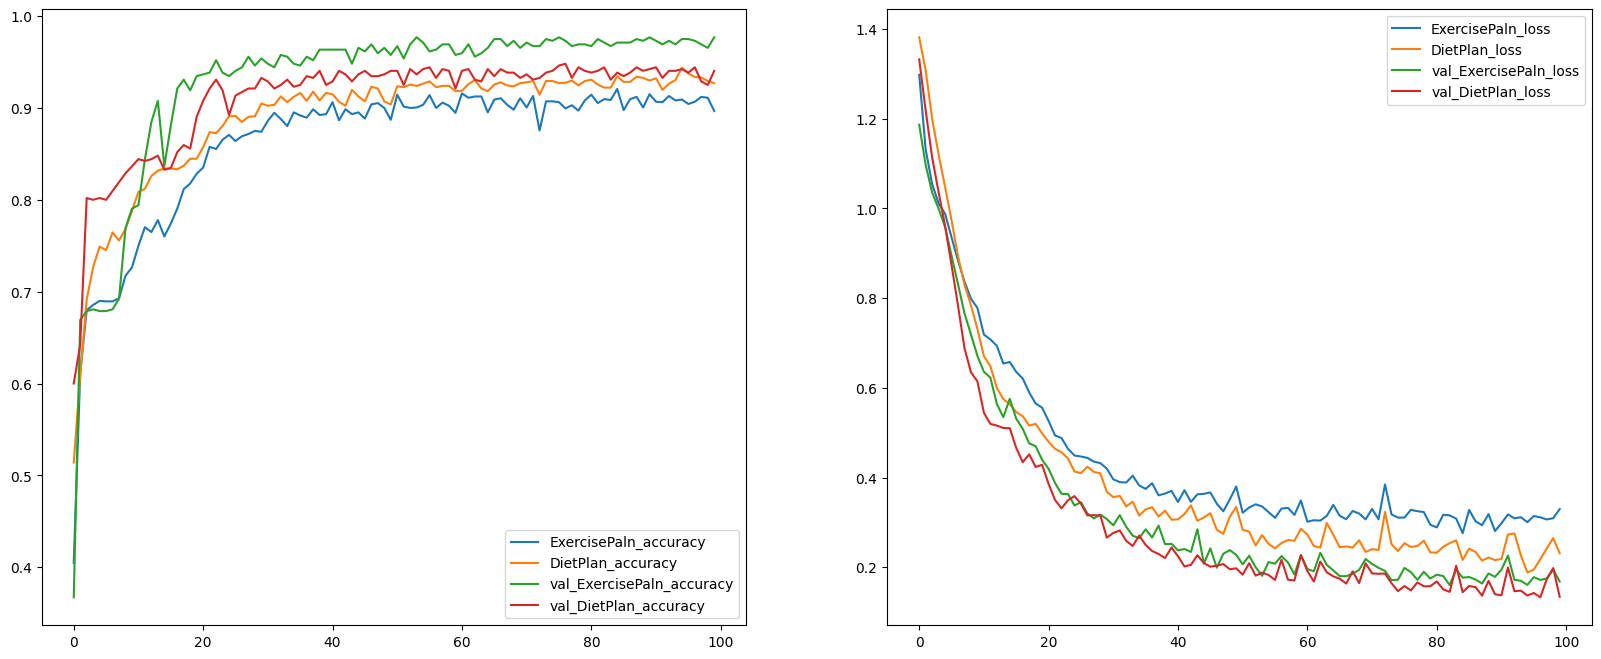

In [10]:
plt.rcParams['figure.figsize'] = (20, 8)

plt.subplot(121)
plt.plot(history.history['ExercisePaln_accuracy'], label='ExercisePaln_accuracy')
plt.plot(history.history['DietPlan_accuracy'], label='DietPlan_accuracy')
plt.plot(history.history['val_ExercisePaln_accuracy'], label='val_ExercisePaln_accuracy')
plt.plot(history.history['val_DietPlan_accuracy'], label='val_DietPlan_accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['ExercisePaln_loss'], label='ExercisePaln_loss')
plt.plot(history.history['DietPlan_loss'], label='DietPlan_loss')
plt.plot(history.history['val_ExercisePaln_loss'], label='val_ExercisePaln_loss')
plt.plot(history.history['val_DietPlan_loss'], label='val_DietPlan_loss')
plt.legend()
plt.show()

# INFERENCE

In [44]:
excercise_plan_mapping = {
                        0: 'No exercises',
                        1: 'sleep,Rest, Yoga',
                        2: 'jogging, walking, Running',
                        3: 'swimming, Breathing exercises'
                        }

diet_plan_mapping = {
                    0: 'No food plan',
                    1: 'Low cholesterol food',
                    2: 'Balance Diet which contain all the nutrients',
                    3: 'Hot Beverages & Meals Food rich in potassium'
                    }

In [45]:
diet_workout_model = tf.keras.models.load_model('weights/diet_workout_prediction.h5')
diet_workout_model.compile(
                        loss='sparse_categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy']
                        )

with open('weights/scalar - diet_workout_prediction.pkl', 'rb') as f:
    scalar = pickle.load(f)

In [56]:
df_all = pd.read_csv('data/diet_workout_dataset.csv')
sample_data = df_all[-50:][["HeartRate","BloodOxygenLevel","BodyTemperature"]]

Xinf = sample_data.values
Xinf = scalar.transform(Xinf)

exercise_plan_idxs, diet_plan_idxs = diet_workout_model.predict(Xinf)
exercise_plan_idxs = exercise_plan_idxs.squeeze()
diet_plan_idxs = diet_plan_idxs.squeeze()

exercise_plan_idxs = np.argmax(exercise_plan_idxs, axis=1)
diet_plan_idxs = np.argmax(diet_plan_idxs, axis=1)

exercise_plans = [excercise_plan_mapping[idx] for idx in exercise_plan_idxs]
diet_plans = [diet_plan_mapping[idx] for idx in diet_plan_idxs]

mode_exercise_plan = max(set(exercise_plans), key=exercise_plans.count)
mode_diet_plan = max(set(diet_plans), key=diet_plans.count)

2/2 [==============================] - 0s 3ms/step
